In [2]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [3]:
dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100.0%


Extracting C:\Users\isco/datasets\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\isco/datasets\MNIST\raw



100.0%


Extracting C:\Users\isco/datasets\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\isco/datasets\MNIST\raw



100.0%


Extracting C:\Users\isco/datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\isco/datasets\MNIST\raw



100.0%

Extracting C:\Users\isco/datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\isco/datasets\MNIST\raw



In [11]:
class Encoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(x_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc2(h)
        logvar = self.fc3(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, x_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        return self.sigmoid(self.fc2(h))


In [13]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.decoder = Decoder

    def forward(self, x):
        mu, logvar = self.encoder(x.view(-1, x_dim))
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

In [16]:
from torch.optim import Adam

encoder = Encoder(x_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, x_dim = x_dim)

model = Model(Encoder=encoder,Decoder=decoder).to(DEVICE)
optimizer = Adam(model.parameters(), lr=lr)

In [17]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, x_dim), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [22]:
model.train()
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))


	Epoch 1 complete! 	Average Loss:  123.86983884273268
	Epoch 2 complete! 	Average Loss:  116.32604162862583
	Epoch 3 complete! 	Average Loss:  112.44187040249373
	Epoch 4 complete! 	Average Loss:  110.3081404717498
	Epoch 5 complete! 	Average Loss:  109.07113595902024
	Epoch 6 complete! 	Average Loss:  108.15544364305092
	Epoch 7 complete! 	Average Loss:  107.59809280115296
	Epoch 8 complete! 	Average Loss:  107.11888086589629
	Epoch 9 complete! 	Average Loss:  106.6822241659276
	Epoch 10 complete! 	Average Loss:  106.36771060491444
	Epoch 11 complete! 	Average Loss:  106.07811536480071
	Epoch 12 complete! 	Average Loss:  105.83832761633974
	Epoch 13 complete! 	Average Loss:  105.66343048961811
	Epoch 14 complete! 	Average Loss:  105.47379118191778
	Epoch 15 complete! 	Average Loss:  105.34063099958264
	Epoch 16 complete! 	Average Loss:  105.16821212437395
	Epoch 17 complete! 	Average Loss:  105.05281375534746
	Epoch 18 complete! 	Average Loss:  104.90316732314274
	Epoch 19 complete! 	

In [24]:
import matplotlib.pyplot as plt
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

  0%|          | 0/100 [00:02<?, ?it/s]


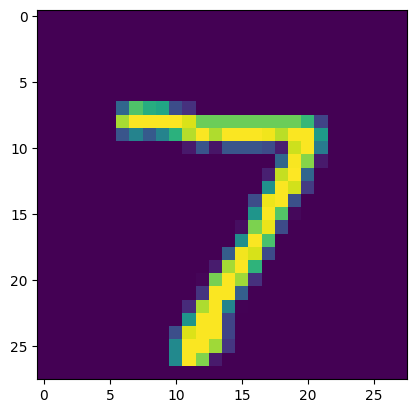

In [25]:
show_image(x, idx=0)


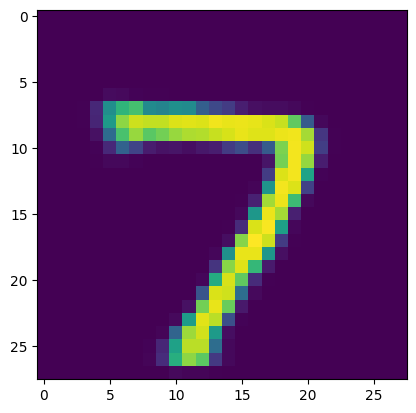

In [26]:
show_image(x_hat, idx=0)
